<a href="https://colab.research.google.com/github/SavkinEgor/MADE_ML_Speech/blob/main/SPEECH_asr_lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [1]:
!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
679MB [00:04, 150MB/s]
/content/lab3


In [2]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

In [4]:
# объединение кадров признаков с соответствующими им фонемам:
# side_context - контест справа и слева
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = [] # соответсиве фонема - MFCC
    priors_list = [0] * len(phones_dict) # веорятность как часто какая фонема считается
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]
        for frame in range(min(len(file_feats), len(file_ali))):
            data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = None
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [5]:
# Добавленный код

# объединение кадров признаков с соответствующими им фонемам:
# side_context - контест справа и слева
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = [] # соответсиве фонема -MFCC
    priors_list = [0] * len(phones_dict) # веорятность как часто какая фонема считается
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]
        for frame in range(1, min(len(file_feats), len(file_ali)) - 1):
          # - - - - - - - - - - - ADDITIONAL CODE HERE - - - - - - - - - - -
            if side_context:
                data_list.append(np.concatenate((
                      file_feats[frame - 1],
                      file_feats[frame],
                      file_feats[frame + 1],
                      [phones_dict[file_ali[frame]]],
                      )))
            else:
                data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
          # - - - - - - - - - - - ADDITIONAL CODE HERE - - - - - - - - - - -
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = True # CONTEXT FLAG
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [6]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(self.device), batch_ys.to(self.device)

In [7]:
class MyNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 256
        n_nodes_hl2 = 256
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return (x)

In [24]:
class MyNetUpgraded(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNetUpgraded, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 512
        n_nodes_hl2 = 512
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)
        # BN layers:
        self.bn1 = nn.BatchNorm1d(n_nodes_hl1)
        self.bn2 = nn.BatchNorm1d(n_nodes_hl2)
        self.bn3 = nn.BatchNorm1d(n_nodes_hl3)
        self.bn4 = nn.BatchNorm1d(n_nodes_hl4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = torch.relu(self.fc4(x))
        x = self.bn4(x)
        x = self.fc5(x)
        return (x)

In [50]:
class MyNetUpgraded(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNetUpgraded, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 512
        n_nodes_hl2 = 512
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)
        # DO layers:
        self.do1 = nn.Dropout(0.2)
        self.do2 = nn.Dropout(0.2)
        self.do3 = nn.Dropout(0.2)
        self.do4 = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.do1(x)
        x = torch.relu(self.fc2(x))
        x = self.do2(x)
        x = torch.relu(self.fc3(x))
        x = self.do3(x)
        x = torch.relu(self.fc4(x))
        x = self.do4(x)
        x = self.fc5(x)
        return (x)

In [9]:
# class MyOwnNet(torch.nn.Module):

#     def __init__(self, input_dim, output_dim):
#         super(MyOwnNet, self).__init__()
#         # params:
#         self.input_dim = input_dim       # размерность входных признаков
#         self.context = 3

#         n_nodes_hl1 = 3 * 8 * 256
#         n_nodes_hl2 = 512
#         n_nodes_hl3 = 256
#         n_nodes_hl4 = 512
#         output_dim = output_dim     # количество выходных классов (фонем)
#         # FC layers:
#         self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
#         self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
#         self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
#         self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
#         self.fc5 = nn.Linear(n_nodes_hl4, output_dim)
#         # CONV layers:
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, padding=1)
#         # self.conv3 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, padding=1)
#         # POOLING layers:
#         self.pool1 = nn.AvgPool1d(4)
#         self.pool2 = nn.AvgPool1d(8)
#         # self.pool11 = nn.MaxPool1d(8)
#         # BATCHNORM layers:
#         self.batchnorm1 = nn.BatchNorm1d(4)
#         self.batchnorm1 = nn.BatchNorm1d(8)
#         # DROPOUT layers:
#         self.dropout1 = nn.Dropout(0.2)
#         self.dropout2 = nn.Dropout(0.2)

#     def forward(self, x):
#         # x = torch.relu(self.fc1(x))
#         # x = x.reshape(self.context, 1, self.input_dim)
#         x = x.reshape(256, 1, self.input_dim)
#         x = self.pool1(self.conv1(x))
#         x = self.dropout1(x)
#         x = self.pool2(self.conv2(x))
#         x = self.dropout2(x)
#         # x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc2(x))
#         # x = torch.relu(self.fc4(x))
#         # torch.squeeze(x)
#         x = self.fc5(x)
#         return (x)

In [ ]:
# c1 = nn.Conv1d(1, 2, 3, padding=1)
# p1 = nn.MaxPool1d(2)
# b1 = nn.BatchNorm1d(2)

In [ ]:
# tmp = torch.rand(39)

In [ ]:
# res1 = c1(tmp.reshape(3,1,13))

In [ ]:
# res2 = p1(res1)

In [ ]:
# b1(res2).shape

torch.Size([3, 2, 6])

In [ ]:
# net = MyOwnNet(input_dim=(data_list[0].shape[0] - 1),
#             output_dim=len(phones_dict.keys())).to(device)

In [ ]:
9984 / 256

39.0

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# batch_size = 256

In [ ]:
# data_set = CommonDataSet(data_list, device)
# batch_xs, batch_ys = next(data_set.next_batch(batch_size))

In [ ]:
# batch_xs.shape

torch.Size([256, 39])

In [ ]:
# net(batch_xs)

RuntimeError: ignored

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
net = MyNetUpgraded(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...



loss is: 2.3752



loss is: 2.0412



loss is: 1.9517



loss is: 1.9015



loss is: 1.8687



loss is: 1.8434



loss is: 1.8253



loss is: 1.8092



loss is: 1.7953



loss is: 1.7828
Time is: 1 min 50 sec


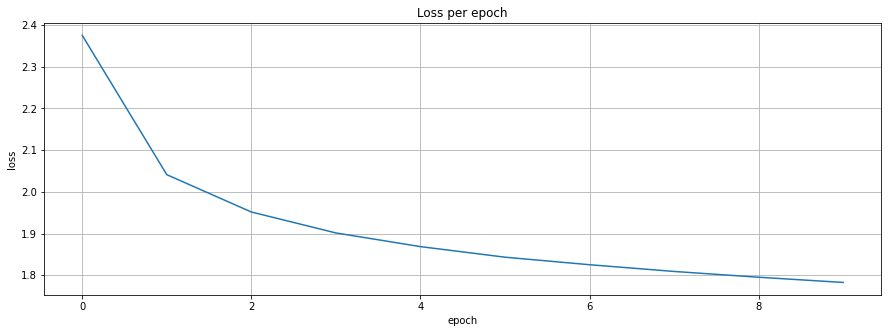

In [52]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [30]:
ftr

tensor([-6.3775e+02,  1.1790e+02,  8.5892e+00,  5.4900e+01, -1.7413e+01,
         2.2536e+00,  2.6324e+01, -1.7889e+01, -1.2616e+01, -9.4394e+00,
         2.9284e+00,  1.0748e+01,  3.4030e+00, -6.5154e+02,  1.0941e+02,
         9.7302e+00,  6.9203e+01,  1.4413e+01, -1.0435e+01,  1.6133e+01,
        -1.9655e+01, -2.3439e+01, -5.6126e+00,  1.3551e+01,  1.6716e+01,
         3.8319e+00, -6.4770e+02,  1.0489e+02,  5.7841e+00,  4.9001e+01,
         1.6701e+01, -1.4983e+01,  1.7104e+01,  1.6798e+00, -1.7255e+01,
        -4.8204e+00,  1.8035e+01,  1.2241e+01,  2.9365e-01])

In [53]:
net.cpu()
net.eval()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        # output = net.forward(ftr.reshape(1,ftr.shape[0]))
        output = net.forward(ftr)
        correct_cnt += (output.argmax().item() == true_label)
        
    print("Total frame accuracy is {:.3f}".format(correct_cnt / data_set.valid.shape[0]))


Total frame accuracy is 0.507


In [54]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]
net.cpu()
with torch.no_grad():
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        # output = net.forward(ftr.reshape(1,ftr.shape[0]))
        output = net.forward(ftr)
        predict_label = output.argmax().item()
        
        class_correct[predict_label] += (predict_label == int(true_label))
        class_total[int(true_label)] += 1

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))


SIL: 0.97 : 21625/22388
SPN: 0.00 : 0/551
AA0: 0.00 : 0/38
AA1: 0.42 : 708/1694
AA2: 0.00 : 0/67
AE0: 0.00 : 0/35
AE1: 0.53 : 1941/3669
AE2: 0.00 : 0/88
AH0: 0.36 : 2023/5649
AH1: 0.18 : 353/1961
AH2: 0.00 : 0/60
AO0: 0.00 : 0/25
AO1: 0.39 : 732/1893
AO2: 0.00 : 0/48
AW0: 0.00 : 0/11
AW1: 0.24 : 274/1126
AW2: 0.00 : 0/47
AY0: 0.00 : 0/27
AY1: 0.52 : 1496/2865
AY2: 0.00 : 0/194
B  : 0.27 : 408/1530
CH : 0.19 : 167/873
D  : 0.28 : 1134/3984
DH : 0.20 : 380/1920
EH0: 0.00 : 0/56
EH1: 0.26 : 751/2860
EH2: 0.00 : 0/95
ER0: 0.33 : 892/2665
ER1: 0.15 : 149/966
ER2: 0.00 : 0/17
EY0: 0.00 : 0/32
EY1: 0.54 : 1281/2377
EY2: 0.00 : 0/140
F  : 0.55 : 1295/2368
G  : 0.07 : 51/769
HH : 0.37 : 802/2153
IH0: 0.09 : 235/2729
IH1: 0.18 : 369/2061
IH2: 0.00 : 0/116
IY0: 0.31 : 676/2176
IY1: 0.58 : 1340/2318
IY2: 0.00 : 0/59
JH : 0.15 : 102/681
K  : 0.44 : 1314/3002
L  : 0.60 : 2417/4015
M  : 0.41 : 1314/3181
N  : 0.61 : 3619/5948
NG : 0.20 : 270/1347
OW0: 0.00 : 0/216
OW1: 0.38 : 719/1911
OW2: 0.00 : 0/1

### Распознавание по словарю с помощью нейронки

In [38]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [55]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [19]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(len(features)):
        ftr_frame = features[frame]
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    # Добавить констекст тоже
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [20]:
def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(1, len(features) - 1):
      # - - - - - - - - - - - ADDITIONAL CODE HERE - - - - - - - - - - -
        ftr_frame = np.concatenate((features[frame - 1], features[frame], features[frame + 1]))
      # - - - - - - - - - - - ADDITIONAL CODE HERE - - - - - - - - - - -
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    # Добавить констекст тоже
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [21]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [ ]:
# Без контекста
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: no_ad89eb1e_nohash_0        ==> NO
result: no_4394fc7c_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
------------------------------------------------------------
WER is: 0.00%
Total time is: 2.06 sec
------------------------------------------------------------


In [ ]:
# С контекстом
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: no_ad89eb1e_nohash_0        ==> NO
result: no_4394fc7c_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
------------------------------------------------------------
WER is: 10.00%
Total time is: 1.97 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [ ]:
# Без контекста
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50)


result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> THREE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: eight_da584bc0_nohash_4     ==> SIX
result: nine_ccea893d_nohash_0      ==> NINE
result: two_fb2f3242_nohash_0       ==> TWO
result: four_fce65496_nohash_0      ==> FOUR
result: two_fce65496_nohash_0       ==> TWO
result: seven_fd32732a_nohash_0     ==> SEVEN
result: one_fc2411fe_nohash_0       ==> NINE
result: one_ffa76c4a_nohash_0       ==> FOUR
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: five_f852895b_nohash_0      ==> FIVE
result: three_fce96bac_nohash_0     ==> THREE
result: eight_daf230ac_nohash_0     ==> SIX
result: three_feb1d305_nohash_0     ==> THREE
result: six_ffbb695d_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
------------------------------------------------------------
WER is: 30.00%
Total time is: 16.76 sec

In [ ]:
# С контекстом
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50)


result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: eight_da584bc0_nohash_4     ==> EIGHT
result: nine_ccea893d_nohash_0      ==> NINE
result: two_fb2f3242_nohash_0       ==> TWO
result: four_fce65496_nohash_0      ==> FOUR
result: two_fce65496_nohash_0       ==> TWO
result: seven_fd32732a_nohash_0     ==> SEVEN
result: one_fc2411fe_nohash_0       ==> NINE
result: one_ffa76c4a_nohash_0       ==> ONE
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: five_f852895b_nohash_0      ==> FIVE
result: three_fce96bac_nohash_0     ==> THREE
result: eight_daf230ac_nohash_0     ==> EIGHT
result: three_feb1d305_nohash_0     ==> THREE
result: six_ffbb695d_nohash_0       ==> SIX
result: six_ffd2ba2f_nohash_0       ==> SIX
------------------------------------------------------------
WER is: 5.00%
Total time is: 15.71 se

### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

Качестов выросло очень приличо, особенно заметно это на датасете с цифрами. На датасете с YES-NO качество упало.

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

In [48]:
# С батчнормом
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        nnet.eval()
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32).reshape(1, input_feats.shape[0]))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальным в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [56]:
# Ээээксепримент 1
net.eval()
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: yes_ff63ab0b_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 0.00%
Total time is: 2.60 sec
------------------------------------------------------------


In [57]:
# Ээээксепримент 1
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50)


result: five_f852895b_nohash_0      ==> FIVE
result: two_fce65496_nohash_0       ==> TWO
result: four_fce65496_nohash_0      ==> FOUR
result: one_ffa76c4a_nohash_0       ==> FOUR
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: zero_f852895b_nohash_0      ==> ZERO
result: seven_fd32732a_nohash_0     ==> SEVEN
result: six_ffd2ba2f_nohash_0       ==> SIX
result: eight_daf230ac_nohash_0     ==> EIGHT
result: six_ffbb695d_nohash_0       ==> SIX
result: two_fb2f3242_nohash_0       ==> TWO
result: three_fce96bac_nohash_0     ==> THREE
result: nine_ccea893d_nohash_0      ==> NINE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_fc2411fe_nohash_0       ==> ONE
result: four_ffbb695d_nohash_0      ==> FOUR
result: eight_da584bc0_nohash_4     ==> EIGHT
result: three_feb1d305_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 5.00%
Total time is: 21.40 se

In [ ]:
# слои поменять
# ignore index в лоссе
# добавить шедулер

Чуть экспериментов

Оригинальная сеть:  
frame accuarcy: 0.424  
WER YES-NO: 0%  
WER DIGITS: 30%  
Сеть с контекстом в 1 и с нормализацией:  
frame accuarcy: 0.527  
WER YES-NO: не запустилось, надо разобраться  
WER DIGITS: не запустилось, надо разобраться 
Сеть с контекстом в 1 и с нормализацией и дропаутом:  
frame accuarcy: 0.507  
WER YES-NO: 0%  
WER DIGITS: 5% 